In [1]:
from fastai2.vision.all import *

In [2]:
path=untar_data(URLs.MNIST_TINY)

In [3]:
Path('/home/fast/.fastai/data').ls()

(#41) [Path('/home/fast/.fastai/data/imagenette-160.tgz'),Path('/home/fast/.fastai/data/imagenette-160'),Path('/home/fast/.fastai/data/mnist.pkl.gz'),Path('/home/fast/.fastai/data/imagenette.tgz'),Path('/home/fast/.fastai/data/imagenette'),Path('/home/fast/.fastai/data/danbooru2018'),Path('/home/fast/.fastai/data/horse2zebra'),Path('/home/fast/.fastai/data/Selfie-dataset'),Path('/home/fast/.fastai/data/oxford-iiit-pet'),Path('/home/fast/.fastai/data/planet_tiny')...]

In [4]:
db=DataBlock((ImageBlock, CategoryBlock), get_items=get_image_files, splitter=GrandparentSplitter(),
                   get_y=parent_label,batch_tfms=aug_transforms(do_flip=False))

In [5]:
dls=db.dataloaders(path,bs=16)

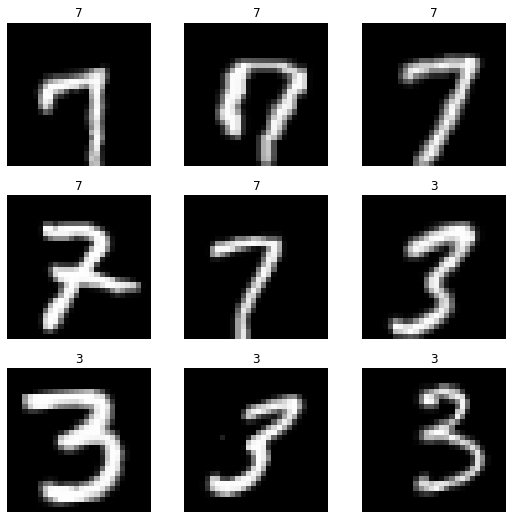

In [6]:
dls.show_batch()

In [7]:
learner=cnn_learner(dls,resnet34)

(0.002290867641568184, 3.6307804407442745e-07)

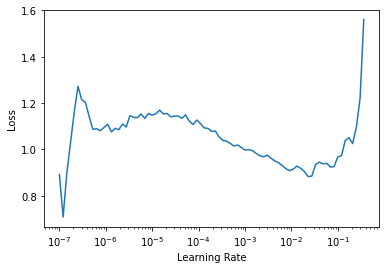

In [8]:
learner.lr_find(num_it=100)

In [9]:
learner.fit_one_cycle(2,lr_max=0.014)

epoch,train_loss,valid_loss,time
0,0.671510,0.095155,00:07
1,0.432407,0.118927,00:07


In [10]:
learner.unfreeze()

In [11]:
#learner.lr_find(num_it=100)

In [12]:
learner.fit_one_cycle(3,lr_max=0.0001)

epoch,train_loss,valid_loss,time
0,0.181299,0.076251,00:07
1,0.234579,0.031906,00:07
2,0.173468,0.038279,00:07


## End of Last Session

In [13]:
from fastai2.callback.wandb import WandbCallback
import wandb

In [14]:
wandb.init()
learner.add_cb(WandbCallback(valid_dl=learner.dls.valid))

In [15]:
learner.fit_one_cycle(3,lr_max=0.0001,moms=(0.5,0.5,0.5))

epoch,train_loss,valid_loss,time
0,0.165175,0.065662,00:11
1,0.116849,0.029303,00:10
2,0.094338,0.020031,00:11


In [16]:
del learner.model

In [17]:
del learner

## End of 5/24

GO OVER Adam!!!!!! 

### Optimizers

#### SGD

In [14]:
x = torch.randn([10,3,32,32])
m = nn.Sequential(nn.Conv2d(3,32,7,3,3),nn.Flatten(),nn.Linear(3872,2))
l = nn.CrossEntropyLoss()
lr=0.1
opt=SGD(m.parameters(),lr)

In [15]:
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()

In [16]:
class OurSGD:
    def __init__(self,params,lr):
        self.params,self.lr=params,lr
    def step(self):
        updated_params=[]
        for p in self.params:
            updated_params.append(p.add(-self.lr*p.grad))
        return updated_params

In [ ]:
p-self.lr*p.grad

In [17]:
our_sgd=OurSGD(m.parameters(),lr)

In [18]:
our_parameters=our_sgd.step()

In [22]:
sgd_step??

In [19]:
opt.step()

In [20]:
def parameters_equal(mps,ops):
    for mp,op in zip((mps),ops):
        print(mp.allclose(op))
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


##### SGD with Momentum

In [25]:
x = torch.randn([10,3,32,32])
m = nn.Sequential(nn.Conv2d(3,32,7,3,3),nn.Flatten(),nn.Linear(3872,2))
l = nn.CrossEntropyLoss()
lr=0.1
mom=0.9
opt=SGD(m.parameters(),lr,mom)

In [32]:
imgb=ImageBlock()

In [36]:
imgb.item_tfms[0]

fastai2.data.transforms.ToTensor

In [40]:
TransformBlock??

In [38]:
ToTensor??

In [30]:
TransformBlock??

In [28]:
DataBlock??

In [26]:
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()

In [27]:
class OurSGDwithMomentum:
    def __init__(self,params,lr,mom):
        self.params,self.lr=list(params),lr
        self.mom=mom ##added
        self.avg_grad=[torch.zeros_like(p) for p in self.params] #added
    def step(self):
        updated_params=[]
        for i,p in enumerate(self.params):
            updated_params.append(p.add(-self.lr*self.mom_grad(i,p.grad)))
        return updated_params
    #avg_grad is weighted average using momentum
    def mom_grad(self,i,grad):
        self.avg_grad[i]=self.mom*self.avg_grad[i]+grad
        return self.avg_grad[i]

In [28]:
our_sgd=OurSGDwithMomentum(m.parameters(),lr,mom)

In [ ]:
p-lr*(mom*avg+grad)

In [29]:
our_parameters=our_sgd.step()

In [30]:
opt.step()

In [31]:
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


Now for step #2! 

In [32]:
our_parameters=our_sgd.step()

In [33]:
opt.step()

In [34]:
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


##### SGD with Weight Decay

For SGD Weight Decay and l2_Regularization are effectively the same. One on the weights, one on the gradients. This is not the same for more complicated optimizers. 

In [35]:
x = torch.randn([10,3,32,32])
m = nn.Sequential(nn.Conv2d(3,32,7,3,3),nn.Flatten(),nn.Linear(3872,2))
l = nn.CrossEntropyLoss()
lr=0.1
mom=0.9
wd=0.01
opt=SGD(m.parameters(),lr,mom,wd)

In [36]:
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()

In [ ]:
ax+by+cz=A
a=1000
b=0.1
c=0.001

In [37]:
class Momentum:
    def __init__(self,params,lr,mom):
        self.mom=mom
        self.params=params
        self.avg_grads=[torch.zeros_like(p) for p in self.params] #avg_grad is weighted average using momentum
    def __call__(self,**kwargs):
        self.avg_grads = [ self.mom*avg_grad+p.grad for p,avg_grad in zip(self.params,self.avg_grads) ]
        return {'avg_grads': self.avg_grads,**kwargs}
class Weight_Decay:
    def __init__(self,params,lr,wd):
        self.lr=lr
        self.wd=wd
        self.params=params
    def __call__(self,**kwargs):
        return {**kwargs,'params':[p*(1-self.lr*self.wd) for p in self.params]} #same as params-lr*wd*params
class OurSGD:
    def __init__(self,params,lr,mom,wd):
        self.params,self.lr=list(params),lr
        self.mom=Momentum(self.params,self.lr,mom)
        self.wd=Weight_Decay(self.params,self.lr,wd)
    def step(self):
        updated_params=[]
        self.params=self.wd()['params']
        avg_grads=self.mom()['avg_grads']
        for i,p in enumerate(self.params):
            updated_params.append(p.add(-self.lr*avg_grads[i])) 
        return updated_params

In [38]:
our_sgd=OurSGD(m.parameters(),lr,mom,wd)

In [39]:
our_parameters=our_sgd.step()

In [40]:
opt.step()

In [41]:
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


In [42]:
opt.zero_grad()
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()
our_parameters=our_sgd.step()
opt.step()
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


##### SGD with l2 reg

l2 reg and weight decay have very similar effects, so no reason to use both. 

In [43]:
x = torch.randn([10,3,32,32])
m = nn.Sequential(nn.Conv2d(3,32,7,3,3),nn.Flatten(),nn.Linear(3872,2))
l = nn.CrossEntropyLoss()
lr=0.1
mom=0.9
wd=0.01
opt=SGD(m.parameters(),lr,mom,wd,decouple_wd= False)

In [44]:
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()

We are doing a bit of refactoring here to remove momentum and weight decay specific logic here. WE also split off the sgd_specific step while we are at it. 

In [45]:
class Momentum:
    def __init__(self,params=None,lr=0.0001,mom=0.9,**kwargs):
        self.mom=mom
        self.params=params
        self.avg_grads=[torch.zeros_like(p) for p in self.params] #avg_grad is weighted average using momentum
    def __call__(self,params=None,**kwargs):
        params = self.params if params is None else params
        self.avg_grads = [ self.mom*avg_grad+p.grad for p,avg_grad in zip(params,self.avg_grads) ]
        return {**kwargs,'params':params,'avg_grads': self.avg_grads}
class Weight_Decay:
    def __init__(self,params=None,lr=0.0001,wd=0.01,decouple=True,**kwargs):
        self.lr=lr
        self.wd=wd
        self.params=params
        self.decouple=decouple
    def __call__(self,**kwargs):
        params = self._do_wd() if self.decouple else self._do_l2_reg()
        return {**kwargs,'params':params}
    def _do_wd(self,**kwargs):
        params=[p*(1-self.lr*self.wd) for p in self.params]
        for p,mp in zip(params,self.params):
            p.grad=mp.grad
        return params #same as params-lr*wd*params
    #this one is pretty ugly 
    def _do_l2_reg(self,**kwargs):
        params=[deepcopy(p) for p in self.params]
        for p,mp in zip(params,self.params):
            p.grad=mp.grad + self.wd* mp
        return params
class OurSGD:
    hypers=[Weight_Decay,Momentum]
    def __init__(self,params,lr,**kwargs):
        self.lr=lr
        self.params=params
    def __call__(self,params=None,avg_grads=None,**kwargs):
        return {**kwargs,'params':[ p.add(-self.lr*avg) for p,avg in zip(params,avg_grads) ]}
class OurOptimizer:
    def __init__(self,params,lr,opt,**kwargs):
        self.state={'params':list(params),'lr':lr}
        self.cbs=[cls(**self.state,**kwargs) for cls in [*opt.hypers,opt]]
    def step(self):
        state=self.state
        for cb in self.cbs:
            state=cb(**state)
        return state['params']

In [46]:
our_opt=OurOptimizer(m.parameters(),lr,OurSGD,decouple=False)

In [47]:
our_parameters=our_opt.step()

In [48]:
opt.step()

In [49]:
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


In [50]:
opt.zero_grad()
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()
our_parameters=our_opt.step()
opt.step()
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


Done with my refactoring. If you notice there is a issue of lots of for...loops going over the same data. In fastai each function momentum/weight_decay/sgd works on a single parameter at a time, and that is encapsulated in a single for...loop, instead of my approach of passing all the parameters to function that does the looping itself. I just got tired of refactoring at this point and decided to keep what I had.... lots of refactoring happened not in this notebook. 

#### RMSProp

In [235]:
x = torch.randn([10,3,32,32])
m = nn.Sequential(nn.Conv2d(3,32,7,3,3),nn.Flatten(),nn.Linear(3872,2))
l = nn.CrossEntropyLoss()
lr=0.1
mom=0.9
wd=0.01
sqr_mom=0.95
opt=RMSProp(m.parameters(),lr,sqr_mom,mom,wd)

In [236]:
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()

In [237]:
class Momentum:
    def __init__(self,params=None,lr=0.0001,mom=0.9,**kwargs):
        self.mom=mom
        self.params=params
        self.avg_grads=[torch.zeros_like(p) for p in self.params] #avg_grad is weighted average using momentum
    def __call__(self,params=None,**kwargs):
        params = self.params if params is None else params
        self.avg_grads = [ self.mom*avg_grad+p.grad for p,avg_grad in zip(params,self.avg_grads) ]
        return {**kwargs,'params':params,'avg_grads': self.avg_grads}
class Weight_Decay:
    def __init__(self,params=None,lr=0.0001,wd=0.01,decouple=True,**kwargs):
        self.lr=lr
        self.wd=wd
        self.params=params
        self.decouple=decouple
    def __call__(self,**kwargs):
        params = self._do_wd() if self.decouple else self._do_l2_reg()
        return {**kwargs,'params':params}
    def _do_wd(self,**kwargs):
        params=[p*(1-self.lr*self.wd) for p in self.params]
        for p,mp in zip(params,self.params):
            p.grad=mp.grad
        return params #same as params-lr*wd*params
    #this one is pretty ugly 
    def _do_l2_reg(self,**kwargs):
        params=[deepcopy(p) for p in self.params]
        for p,mp in zip(params,self.params):
            p.grad=mp.grad + self.wd* mp
        return params
class OurSGD:
    hypers=[Weight_Decay,Momentum]
    def __init__(self,params,lr,**kwargs):
        self.lr=lr
        self.params=params
    def __call__(self,params=None,avg_grads=None,**kwargs):
        return {**kwargs,'params':[ p.add(-self.lr*avg) for p,avg in zip(params,avg_grads) ]}
class OurOptimizer:
    def __init__(self,params,lr,opt,**kwargs):
        self.state={'params':list(params),'lr':lr}
        self.cbs=[cls(**self.state,**kwargs) for cls in [*opt.hypers,opt]]
    def step(self):
        state=self.state
        for cb in self.cbs:
            state=cb(**state)
        return state['params']

In [238]:
class Learning_Rate_Decay:
    def __init__(self, params=None,sqr_mom=0.99,**kwargs):
        self.sqr_mom=sqr_mom
        self.sqr_avgs=[torch.zeros_like(p) for p in params]
    def __call__(self, params=None, dampening=True, **kwargs):
        damp = 1-sqr_mom if dampening else 1.
        self.sqr_avgs = [sqr_avg * self.sqr_mom + damp * p.grad.data ** 2 for p,sqr_avg in zip(params,self.sqr_avgs)]
        return { **kwargs,'params':params,'sqr_avgs':self.sqr_avgs}

In [239]:
class OurRMSProp:
    hypers=[Weight_Decay,Momentum,Learning_Rate_Decay]
    def __init__(self,lr,params,**kwargs):
        self.lr=lr
        self.params=params
    def __call__(self,params=None,avg_grads=None,eps=1e-08,sqr_avgs=None,**kwargs):
        return {**kwargs,'params':[ p.add(-self.lr*avg/(sqr_avg**(0.5)+eps)) for p,avg,sqr_avg in zip(params,avg_grads,sqr_avgs) ]}

In [240]:
our_opt=OurOptimizer(m.parameters(),lr,OurRMSProp,sqr_mom=0.95)

In [241]:
our_parameters=our_opt.step()

In [242]:
opt.step()

In [243]:
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


In [244]:
opt.zero_grad()
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()
our_parameters=our_opt.step()
opt.step()
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


#### Adam

In [268]:
x = torch.randn([10,3,32,32])
m = nn.Sequential(nn.Conv2d(3,32,7,3,3),nn.Flatten(),nn.Linear(3872,2))
l = nn.CrossEntropyLoss()
lr=0.1
mom=0.9
wd=0.01
eps=1e-05
sqr_mom=0.95
opt=Adam(m.parameters(),lr,mom,sqr_mom,eps,wd)

In [269]:
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()

In [270]:
class Weight_Decay:
    def __init__(self,params=None,lr=0.0001,wd=0.01,decouple=True,**kwargs):
        self.lr=lr
        self.wd=wd
        self.params=params
        self.decouple=decouple
    def __call__(self,**kwargs):
        params = self._do_wd() if self.decouple else self._do_l2_reg()
        return {**kwargs,'params':params}
    def _do_wd(self,**kwargs):
        params=[p*(1-self.lr*self.wd) for p in self.params]
        for p,mp in zip(params,self.params):
            p.grad=mp.grad
        return params #same as params-lr*wd*params
    #this one is pretty ugly 
    def _do_l2_reg(self,**kwargs):
        params=[deepcopy(p) for p in self.params]
        for p,mp in zip(params,self.params):
            p.grad=mp.grad + self.wd* mp
        return params
class OurSGD:
    hypers=[Weight_Decay,Momentum]
    def __init__(self,params,lr,**kwargs):
        self.lr=lr
        self.params=params
    def __call__(self,params=None,avg_grads=None,**kwargs):
        return {**kwargs,'params':[ p.add(-self.lr*avg) for p,avg in zip(params,avg_grads) ]}
class OurOptimizer:
    def __init__(self,params,lr,opt,**kwargs):
        self.state={'params':list(params),'lr':lr}
        self.cbs=[cls(**self.state,**kwargs) for cls in [*opt.hypers,opt]]
    def step(self):
        state=self.state
        for cb in self.cbs:
            state=cb(**state)
        return state['params']
class Learning_Rate_Decay:
    def __init__(self, params=None,sqr_mom=0.99,**kwargs):
        self.sqr_mom=sqr_mom
        self.sqr_avgs=[torch.zeros_like(p) for p in params]
    def __call__(self, params=None, dampening=True, **kwargs):
        damp = 1-sqr_mom if dampening else 1.
        self.sqr_avgs = [sqr_avg * self.sqr_mom + damp * p.grad.data ** 2 for p,sqr_avg in zip(params,self.sqr_avgs)]
        return { **kwargs,'params':params,'sqr_avgs':self.sqr_avgs}
class OurRMSProp:
    hypers=[Weight_Decay,Momentum,Learning_Rate_Decay]
    def __init__(self,lr,params,**kwargs):
        self.lr=lr
        self.params=params
    def __call__(self,params=None,avg_grads=None,eps=1e-08,sqr_avgs=None,**kwargs):
        return {**kwargs,'params':[ p.add(-self.lr*avg/(sqr_avg**(0.5)+eps)) for p,avg,sqr_avg in zip(params,avg_grads,sqr_avgs) ]}

In [271]:
class Step:
    def __init__(self,**kwargs):
        self.step=0
    def __call__(self,**kwargs):
        self.step+=1
        return {'step':self.step,**kwargs}
class Momentum:
    def __init__(self,params=None,lr=0.0001,mom=0.9,**kwargs):
        self.mom=mom
        self.params=params
        self.avg_grads=[torch.zeros_like(p) for p in self.params] #avg_grad is weighted average using momentum
    def __call__(self,params=None,**kwargs):
        params = self.params if params is None else params
        self.avg_grads = [ self.mom*avg_grad+(1-self.mom)*p.grad for p,avg_grad in zip(params,self.avg_grads) ]
        return {**kwargs,'params':params,'avg_grads': self.avg_grads}
class OurAdam:
    hypers=[Weight_Decay,Momentum,Learning_Rate_Decay,Step]
    def __init__(self,lr,params,mom=0.9,sqr_mom=0.99,eps=1e-08,**kwargs):
        self.lr=lr
        self.params=params
        self.mom=mom
        self.sqr_mom=sqr_mom
        self.eps=eps
    def __call__(self,step=1,params=None,avg_grads=None,sqr_avgs=None,**kwargs): #eps=1e-08
        sqr_avgs=[sqr_avg/(1 - sqr_mom**step) for sqr_avg in sqr_avgs]
        avg_grads = [avg_grad / (1 - mom**step) for avg_grad in avg_grads]
        return {**kwargs,'params':[ p.addcdiv( -lr ,grad_avg,(sqr_avg.sqrt() + self.eps )) for p,grad_avg,sqr_avg in zip(params,avg_grads,sqr_avgs) ]}

In [272]:
our_opt=OurOptimizer(m.parameters(),lr,OurAdam,eps=eps,sqr_mom=0.95)

In [273]:
our_parameters=our_opt.step()

In [274]:
opt.step()

In [275]:
#shows parameters close to not being equal
def parameters_equal_show(mps,ops):
    for mp,op in zip((mps),ops):
        print(mp.masked_select((mp-op).abs()>1e-08),op.masked_select((mp-op).abs()>1e-08))
        break

In [281]:
parameters_equal_show(m.parameters(),our_parameters)

tensor([ 0.1133,  0.1766,  0.2099,  0.1881,  0.1587,  0.2367,  0.2189,  0.2101,
         0.1876, -0.2224, -0.2393, -0.1429,  0.2033,  0.1898, -0.1359, -0.1989,
        -0.2205,  0.1676, -0.2199, -0.1297, -0.1014, -0.1833, -0.1241, -0.1455,
        -0.2361,  0.0979, -0.1395, -0.1275,  0.1032,  0.1991, -0.1265, -0.2069,
        -0.2465,  0.2102, -0.0968, -0.2100,  0.1213, -0.1896,  0.1769, -0.2089,
        -0.1518,  0.1592,  0.2491,  0.2233, -0.2382, -0.1474,  0.1746, -0.2236,
         0.2342, -0.1417,  0.1879, -0.1650, -0.2419, -0.1232, -0.2413, -0.2258,
         0.1095, -0.1980, -0.1882, -0.1661, -0.1769,  0.2334, -0.1878,  0.1639,
        -0.2143,  0.1531, -0.1679,  0.2016, -0.1644,  0.1493,  0.2032, -0.1417,
        -0.1873,  0.1333, -0.1954,  0.1659, -0.1852, -0.1532, -0.1191, -0.2032,
         0.2201, -0.1217,  0.1954, -0.1297,  0.2288, -0.1301, -0.2084, -0.2102,
        -0.1571, -0.1803, -0.1516,  0.2013, -0.2338, -0.2348,  0.2308, -0.1777,
        -0.1932,  0.2142, -0.1990,  0.17

In [277]:
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


In [278]:
opt.zero_grad()
pred=m(x)
loss=l(pred,torch.zeros([pred.size()[0]],dtype=torch.long))
loss.backward()
our_parameters=our_opt.step()
opt.step()
parameters_equal(m.parameters(),our_parameters)

True
True
True
True


In [279]:
opt.hypers

(#1) [{'wd': 0.01, 'sqr_mom': 0.95, 'lr': 0.1, 'mom': 0.9, 'eps': 1e-05}]

In [24]:
DataBlock??